In [1]:
import os

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_pickle("../data/dair-ai-emotions/merged_training.pkl")
df

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love
...,...,...
566,that was what i felt when i was finally accept...,joy
36236,i take every day as it comes i m just focussin...,fear
76229,i just suddenly feel that everything was fake,sadness
131640,im feeling more eager than ever to claw back w...,joy


In [3]:
# It is only fine-tuning, thus 400k data samples is a complete overkill. It can be reduced to 40k.
df = df.iloc[:10000]

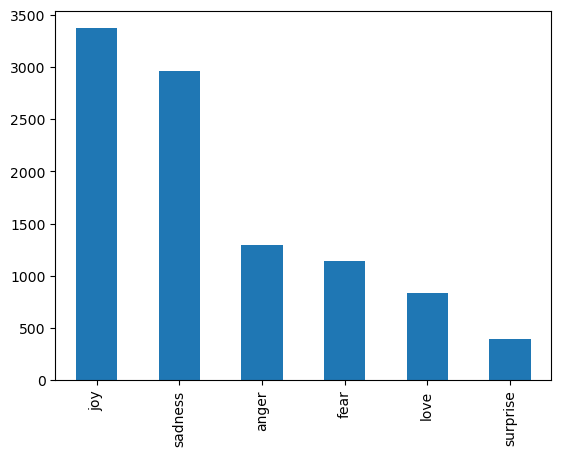

In [4]:
data = df["emotions"]
data.value_counts().plot.bar()
plt.show()

In [5]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [6]:
df = df.replace({"emotions": ordered_class_labels})

In [7]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['text', 'emotions'],
    num_rows: 10000
})

In [8]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [10]:
# Train set: 80%, Validation set: 10%, Test set: 10%
split_train_val_and_test_dataset = tokenized_dataset.train_test_split(train_size=0.8)
split_val_test_dataset = split_train_val_and_test_dataset["test"].train_test_split(test_size=0.5)

tokenized_train_dataset = split_train_val_and_test_dataset["train"]
tokenized_val_dataset = split_val_test_dataset["train"]
tokenized_test_dataset = split_val_test_dataset["test"]

In [11]:
from transformers import DataCollatorWithPadding

batch_size = 16


def convert_to_tf_dataset(hf_dataset, collator, batch_size=batch_size, shuffle=True):
    return hf_dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["emotions"],
        collate_fn=collator,
        shuffle=shuffle,
        batch_size=batch_size,
    )


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = convert_to_tf_dataset(hf_dataset=tokenized_train_dataset, collator=data_collator)
tf_val_dataset = convert_to_tf_dataset(hf_dataset=tokenized_val_dataset, collator=data_collator)
tf_test_dataset = convert_to_tf_dataset(hf_dataset=tokenized_test_dataset, collator=data_collator)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [12]:
import Constants

# Callbacks
training_number = 2
model_name = "emotions_eng_bert"
training_folder = f"training_{training_number}"
checkpoint_filename = "cp-{epoch:04d}.ckpt"
training_path = os.path.join(Constants.TRAINING_CHECKPOINTS_PATH, model_name, training_folder)
checkpoint_path = os.path.join(training_path, checkpoint_filename)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)

early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)

In [26]:
checkpoint_path

'../training_checkpoints\\emotions_eng_bert\\training_2\\cp-{epoch:04d}.ckpt'

In [13]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs. Note that the tf_train_dataset here is a batched tf.data.Dataset,
# not the original Hugging Face Dataset, so its len() is already num_samples // batch_size.
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [14]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=6)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [16]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/10
500/500 [==============================] - 58s 91ms/step - loss: 0.5708 - accuracy: 0.8069 - val_loss: 0.2436 - val_accuracy: 0.9180

Epoch 00001: saving model to ../training_checkpoints\emotions_eng_bert\training_2\cp-0001.ckpt
Epoch 2/10
500/500 [==============================] - 44s 88ms/step - loss: 0.1737 - accuracy: 0.9295 - val_loss: 0.1899 - val_accuracy: 0.9280

Epoch 00002: saving model to ../training_checkpoints\emotions_eng_bert\training_2\cp-0002.ckpt
Epoch 3/10
500/500 [==============================] - 43s 87ms/step - loss: 0.1111 - accuracy: 0.9524 - val_loss: 0.1696 - val_accuracy: 0.9310

Epoch 00003: saving model to ../training_checkpoints\emotions_eng_bert\training_2\cp-0003.ckpt
Epoch 4/10
500/500 [==============================] - 43s 87ms/step - loss: 0.0922 - accuracy: 0.9638 - val_loss: 0.1886 - val_accuracy: 0.9240

Epoch 00004: saving model to ../training_checkpoints\emotions_eng_bert\training_2\cp-0004.ckpt
Epoch 5/10
500/500 [====================

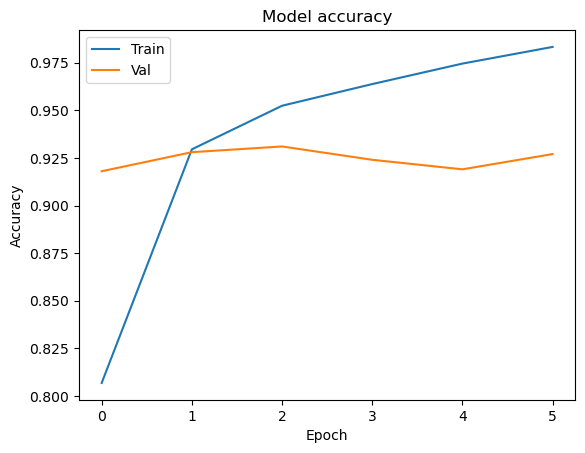

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig(f"../documentation/models/{model_name}/figures/{training_folder}_accuracy.png")
plt.show()

In [19]:
import shutil

best_model_checkpoint_index = np.argmin(history.history["val_accuracy"]) + 1
best_model_weights_path = os.path.join(training_path, checkpoint_filename.format(epoch=best_model_checkpoint_index))
best_model = model
best_model.load_weights(best_model_weights_path)

shutil.rmtree(training_path)

In [21]:
saved_model_name = f"{model_name}_{training_number}"

# Save to Saved Model format
best_model.save(os.path.join(Constants.SAVED_MODEL_LOCATION, saved_model_name, Constants.DEFAULT_MODEL_VERSION))

INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_bert_2\1\assets


INFO:tensorflow:Assets written to: ../trained_models\emotions_eng_bert_2\1\assets


In [22]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=32)

63/63 [==============================] - 2s 34ms/step - loss: 0.2452 - accuracy: 0.9130


[0.2451886385679245, 0.9129999876022339]

In [20]:
# Getting predictions
prediction_logits = best_model.predict(tf_test_dataset)['logits']
probabilities = tf.nn.softmax(prediction_logits)
class_preds = np.argmax(probabilities, axis=1)